# Open or Close Eye Detection

Code for predecting if the eye if closed or open 


In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from collections import Counter
import glob

2025-05-03 03:49:41.162714: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746244181.351195      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746244181.406291      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Reading the images

In [2]:
img_array = cv2.imread('/kaggle/input/mrl-eye-dataset/mrleyedataset/Close-Eyes/s0001_00001_0_0_0_0_0_01.png', cv2.IMREAD_GRAYSCALE)

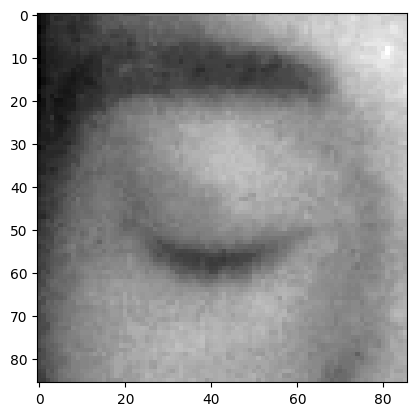

In [3]:
plt.imshow(img_array, cmap="gray")

In [4]:
img_array.shape

(86, 86)

In [5]:
import os

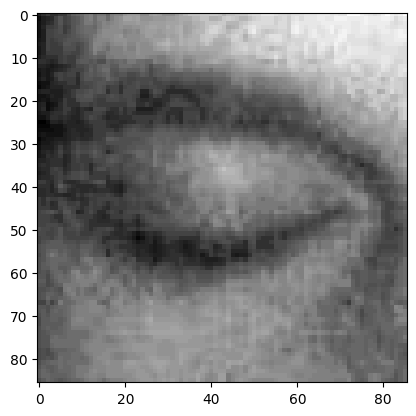

In [6]:
Datadirectory = '/kaggle/input/mrl-eye-dataset/mrleyedataset'
Classes = ['Close-Eyes', 'Open-Eyes']
# Datadirectory = 'dataset_new/train/'
# Classes = ['Closed', 'Open']
for category in Classes:
  path = os.path.join(Datadirectory, category)
  for img in os.listdir(path):
    img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
    backtorgb = cv2.cvtColor(img_array,cv2.COLOR_GRAY2RGB)
    plt.imshow(img_array, cmap="gray")
    plt.show()
    break
  break


In [7]:
Datadirectory = '/kaggle/input/mrl-eye-dataset/mrleyedataset'
Classes = ['Close-Eyes', 'Open-Eyes']

# Get all .png image paths
image_paths = glob.glob(os.path.join(Datadirectory, '**', '*.png'), recursive=True)

# Create binary labels: 0 for closed, 1 for open
label_map = {'Close-Eyes': 0, 'Open-Eyes': 1}
labels = [label_map[os.path.basename(os.path.dirname(path))] for path in image_paths]

print(f"Total images found: {len(image_paths)}")
print(f"Label distribution: {Counter(labels)}")


Total images found: 84898
Label distribution: Counter({1: 42952, 0: 41946})


In [8]:
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42)

print("\nAfter split:")
print(f"Train label counts: {Counter(train_labels)}")
print(f"Test label counts: {Counter(test_labels)}")



After split:
Train label counts: Counter({1: 34361, 0: 33557})
Test label counts: Counter({1: 8591, 0: 8389})


In [9]:
img_size = 224  # MobileNet input size

def save_preprocessed_images(paths, labels, split_type, base_dir='/kaggle/working/split_dataset'):
    for path, label in zip(paths, labels):
        try:
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            resized = cv2.resize(img_rgb, (img_size, img_size))
            dest_dir = os.path.join(base_dir, split_type, str(label))
            os.makedirs(dest_dir, exist_ok=True)
            filename = os.path.basename(path)
            cv2.imwrite(os.path.join(dest_dir, filename), resized)
        except Exception as e:
            print(f"Error processing {path}: {e}")

save_preprocessed_images(train_paths, train_labels, 'train')
save_preprocessed_images(test_paths, test_labels, 'test')


In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/working/split_dataset/train",
    label_mode='int',
    image_size=(224, 224),
    batch_size=32,
    shuffle=True
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/working/split_dataset/test",
    label_mode='int',
    image_size=(224, 224),
    batch_size=32,
    shuffle=False
)


Found 67918 files belonging to 2 classes.


I0000 00:00:1746244832.277330      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 16980 files belonging to 2 classes.


In [11]:
total_train_images = sum(1 for _ in train_ds.unbatch())
print("Total train images loaded:", total_train_images)


Total train images loaded: 67918


In [12]:
# Load MobileNet base (without top layer)
base_model = tf.keras.applications.MobileNet(
    weights=None,
    input_shape=(224, 224, 3),
    include_top=False
)
base_model.load_weights("/kaggle/input/mobilenet/keras/default/1/mobilenet_1_0_224_tf_no_top.h5")
# base_model.trainable = False  # Freeze base

# # Build the full model
# model = tf.keras.Sequential([
#     base_model,
#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification
# ])

# model.compile(
#     optimizer='adam',
#     loss='binary_crossentropy',
#     metrics=['accuracy']
# )


# Extra

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_aug = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0.8, 1.2),
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_gen = train_aug.flow_from_directory(
    '/kaggle/working/split_dataset/train',
    target_size=(224,224),
    batch_size=32,
    class_mode='binary'
)


Found 67918 images belonging to 2 classes.


In [14]:
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Step 1: Build model with frozen base
base_model.trainable = False
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [15]:
# Step 2: Train only head (5–10 epochs)
model.fit(train_gen, validation_data=test_ds, epochs=5)


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1746244881.737949      94 service.cc:148] XLA service 0x7f4e10004a00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746244881.738531      94 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746244882.394483      94 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/2123 ━━━━━━━━━━━━━━━━━━━━ 6:30:20 11s/step - accuracy: 0.6875 - loss: 0.7343

I0000 00:00:1746244885.380126      94 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2123/2123 ━━━━━━━━━━━━━━━━━━━━ 815s 379ms/step - accuracy: 0.8040 - loss: 0.4272 - val_accuracy: 0.9326 - val_loss: 0.1871
Epoch 2/5
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 797s 374ms/step - accuracy: 0.8928 - loss: 0.2697 - val_accuracy: 0.9399 - val_loss: 0.1638
Epoch 3/5
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 792s 372ms/step - accuracy: 0.9022 - loss: 0.2497 - val_accuracy: 0.9469 - val_loss: 0.1523
Epoch 4/5
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 793s 372ms/step - accuracy: 0.9068 - loss: 0.2369 - val_accuracy: 0.9420 - val_loss: 0.1564
Epoch 5/5
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 795s 373ms/step - accuracy: 0.9076 - loss: 0.2320 - val_accuracy: 0.9496 - val_loss: 0.1386


In [16]:
# Step 3: Fine-tune last 10 layers
for layer in base_model.layers[:-10]:
    layer.trainable = False
for layer in base_model.layers[-10:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Step 4: Callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
]

# Step 5: Compute class weights (optional but recommended if imbalance)
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(train_gen.classes)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_gen.classes)
class_weight = dict(zip(classes, weights))

# Step 6: Fine-tune with callbacks and class weights
history_fine = model.fit(
    train_gen,
    validation_data=test_ds,
    epochs=20,
    class_weight=class_weight,
    callbacks=callbacks
)



Epoch 1/20


E0000 00:00:1746248876.118270      96 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746248876.318384      96 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


 885/2123 ━━━━━━━━━━━━━━━━━━━━ 7:36 369ms/step - accuracy: 0.7552 - loss: 8.5923

E0000 00:00:1746249205.596809      93 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746249205.795753      93 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


2123/2123 ━━━━━━━━━━━━━━━━━━━━ 807s 375ms/step - accuracy: 0.8140 - loss: 5.1764 - val_accuracy: 0.7635 - val_loss: 2.6617 - learning_rate: 1.0000e-05
Epoch 2/20
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 810s 380ms/step - accuracy: 0.9086 - loss: 0.3915 - val_accuracy: 0.9615 - val_loss: 0.1158 - learning_rate: 1.0000e-05
Epoch 3/20
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 808s 379ms/step - accuracy: 0.9238 - loss: 0.2057 - val_accuracy: 0.9631 - val_loss: 0.1013 - learning_rate: 1.0000e-05
Epoch 4/20
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 813s 381ms/step - accuracy: 0.9422 - loss: 0.1555 - val_accuracy: 0.9662 - val_loss: 0.0909 - learning_rate: 1.0000e-05
Epoch 5/20
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 826s 388ms/step - accuracy: 0.9499 - loss: 0.1369 - val_accuracy: 0.9297 - val_loss: 0.2023 - learning_rate: 1.0000e-05
Epoch 6/20
2122/2123 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.9557 - loss: 0.1207
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 816s

# done extra


In [17]:
# history = model.fit(
#     train_ds,
#     validation_data=test_ds,
#     epochs=20
# )


In [18]:
loss, acc = model.evaluate(test_ds)
print(f"Test Accuracy: {acc:.4f}")


531/531 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.9790 - loss: 0.0519
Test Accuracy: 0.9791


In [19]:
def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img = cv2.resize(img, (224, 224))
    img = img.astype(np.float32) / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Example usage
image_path = "/kaggle/input/mrl-eye-dataset/mrleyedataset/Open-Eyes/s0001_01842_0_0_1_0_0_01.png"  # Replace with your image
image = load_and_preprocess_image(image_path)



In [20]:
# Predict
prediction = model.predict(image)

# Interpret result
label = "Open Eye" if prediction[0][0] > 0.5 else "Closed Eye"
print(f"Prediction: {label} ({prediction[0][0]:.4f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Prediction: Open Eye (1.0000)


In [21]:
# After training
model.save("eye_model.h5")


In [22]:
!pip freeze > requirements.txt


----- Evaluation Results -----
Accuracy:  0.9791
Precision: 0.9771
Recall:    0.9817
F1 Score:  0.9794


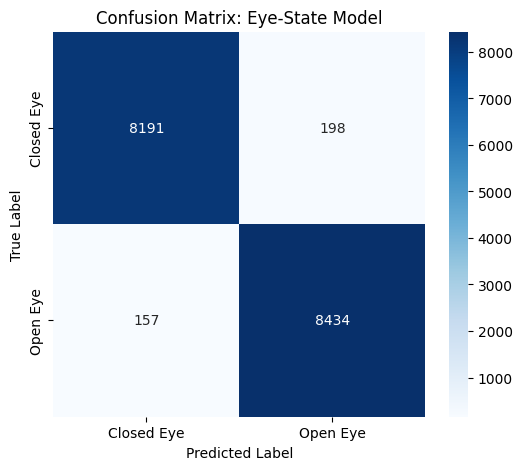

In [23]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ OPTIONAL: Save final trained model
model.save("eye_model.h5")

# ✅ Inference on test dataset
y_true = []
y_pred = []

for images, labels in test_ds:
    # Predict class probabilities
    probs = model.predict(images, verbose=0)  # Shape: (batch, 1)
    preds = (probs.squeeze() > 0.5).astype(int)  # Binary: 0 or 1

    y_true.extend(labels.numpy())
    y_pred.extend(preds)

# ✅ Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# ✅ Compute classification metrics
accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall    = recall_score(y_true, y_pred)
f1        = f1_score(y_true, y_pred)

print("----- Evaluation Results -----")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# ✅ Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Closed Eye", "Open Eye"],
            yticklabels=["Closed Eye", "Open Eye"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix: Eye-State Model")
plt.show()


In [25]:
model.save("new_eye_model.h5")

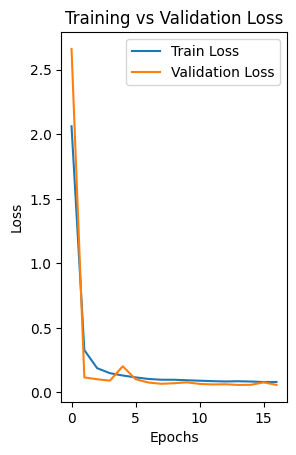

In [27]:
# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_fine.history['loss'], label='Train Loss')
plt.plot(history_fine.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')

plt.show()